# Tick 1

## Code

### Initialization

In [3]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
rng = np.random.default_rng(0)

## Part a

### Question 1

In [4]:
# Example code to generate vector of N sizes for loci
def random_sizes(N, avg_size): return np.random.geometric(1/avg_size, size=N)

def trunc_sizes(s):
    N = len(s)
    cumulative = np.cumsum(s)
    newlength = np.where((cumulative - N) >= 0)[0][0]
    s[newlength] = s[newlength] - (cumulative[newlength] - N)
    return np.array(s[:newlength+1])

### Question 2

In [5]:
def person_in(loc_sizes):
    loci = np.arange(len(loc_sizes))
    return np.repeat(loci, loc_sizes)

def first_occ(loc_sizes):
    s = np.array(loc_sizes)
    return np.append([0], np.cumsum(s)[:-1])

### Question 3

In [6]:
def exposure(infected, loc_sizes):
    numinf = np.cumsum(infected)
    infnum = np.append(numinf[np.cumsum(loc_sizes)[0] - 1], np.diff(numinf[np.cumsum(loc_sizes) - 1]))
    return np.repeat(infnum, loc_sizes)

### Question 4

In [34]:
def sim(N, T, n0, avg_loc_size=2.1, prob_infect=0.07, prob_recover=1/10):
    ninf = n0
    matrix = np.empty((T, 4))
    totalrec = 0
    infdist = np.random.permutation(np.arange(N) < ninf).astype(int)
    for day in range(T):
        
        infdist = rng.permutation(infdist)
        loci = trunc_sizes(random_sizes(N, avg_loc_size))
        
        infected = infdist == 1
        
        numexposed = exposure(infected, loci)
        
        susceptible = (infdist == 0) & (numexposed > 0)
        
        initinf = infected.sum()

        nums = rng.uniform(size=N)
        
        infdist[susceptible] = nums[susceptible] < prob_infect
        
        newinf = (infdist==1).sum() - initinf
        
        torecover = nums[infected] < prob_recover
        infdist[infected] = np.where(torecover, -1, 1)
        recovered = torecover.sum()
        totalrec += recovered

        matrix[day] = np.array([newinf, recovered, (infdist==1).sum(), totalrec])

    return matrix

### Question 5

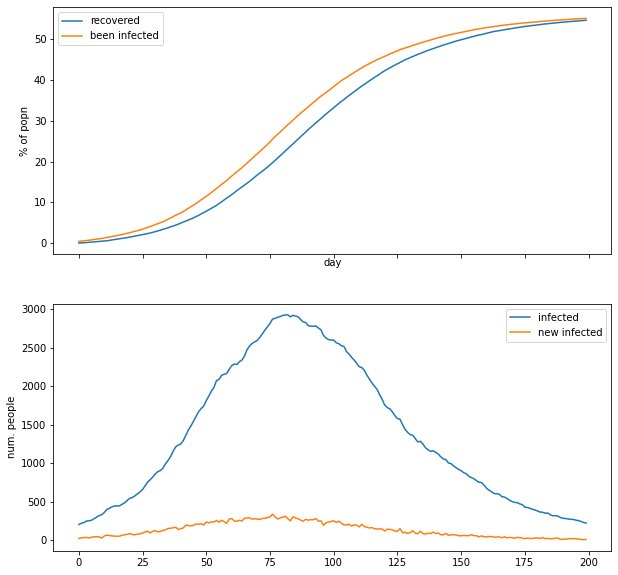

In [8]:
mat = sim(50000, 200, 200)
fig, (ax2, ax1) = plt.subplots(2, 1, sharex = True, figsize=(10, 10))

ax1.plot(mat[:, 2], label='infected')
ax1.plot(mat[:, 0], label='new infected')
ax1.set_ylabel('num. people')
ax1.legend()

ax2.plot(mat[:, 3]/500, label='recovered')
ax2.plot((mat[:, 2]+mat[:, 3])/500, label='been infected')
ax2.set_ylabel('% of popn')
ax2.set_xlabel('day')
ax2.legend()

## Part b

### Question 6

In [22]:
def r(X, t0, t1, days):
    N = np.sum(X[t0:t1, 0])
    # As the 3rd column of the matrix includes new infections on that day 
    # we want infections at the start of each day
    D = np.sum(X[(t0-1):(t1-1), 2])
    return days*N/D

r(mat, 1, 10, 10)

1.506204535729568

### Question 7

In [149]:
# After trunc_sizes has been applied, generates an array of private loci with N total people, given
# that num_households households are allowed to bubble
def bubble_sizes(N, num_households):
    return np.random.choice([1,2,3,4,5,6], p=[.29,.35,.15,.14,.05,.02], size=(num_households,N)).sum(0)

def sim2(N, T, n0, avg_loc_size=2.1, prob_infect=0.07, prob_recover=1/10, prob_infect_home=0.1, num_households=1):
    ninf = n0
    matrix = np.empty((T, 4))
    totalrec = 0
    privloci = trunc_sizes(bubble_sizes(N, num_households))
    # initially put all infected next to each other to simulate infections
    # generally being clustered in households
    infdist = (np.arange(N) < ninf).astype(int)
    for day in range(T):
        
#         infdist = rng.permutation(infdist)
        
        # STAGE 1: RANDOM PUBLIC LOCI INFECTIONS
        
        infdistindices = rng.permutation(np.arange(N))
        inverseinfdistindices = infdistindices.argsort()
        infdist = infdist[infdistindices]
        
        publoci = trunc_sizes(random_sizes(N, avg_loc_size))
        
        infected = infdist == 1
        
        numexposed = exposure(infected, publoci)
        
        susceptible = (infdist == 0) & (numexposed > 0)
        
        initinf = infected.sum()

        nums = rng.uniform(size=N)
        
        infdist[susceptible] = nums[susceptible] < prob_infect
        
#         newinf = (infdist==1).sum() - initinf

        
        infdist = infdist[inverseinfdistindices]
        
        # STAGE 2: HOME BUBBLE INFECTIONS
        
        infected = infdist == 1
        
        numexposed = exposure(infected, privloci)
        
        susceptible = (infdist == 0) & (numexposed > 0)
        
        infdist[susceptible] = nums[susceptible] < prob_infect_home
        
        newinf = (infdist==1).sum() - initinf
        
        # STAGE 3: RECOVERY
       
        torecover = nums[infected] < prob_recover
        infdist[infected] = np.where(torecover, -1, 1)
        recovered = torecover.sum()
        totalrec += recovered
        

        matrix[day] = np.array([newinf, recovered, (infdist==1).sum(), totalrec])

    return matrix

### Question 8

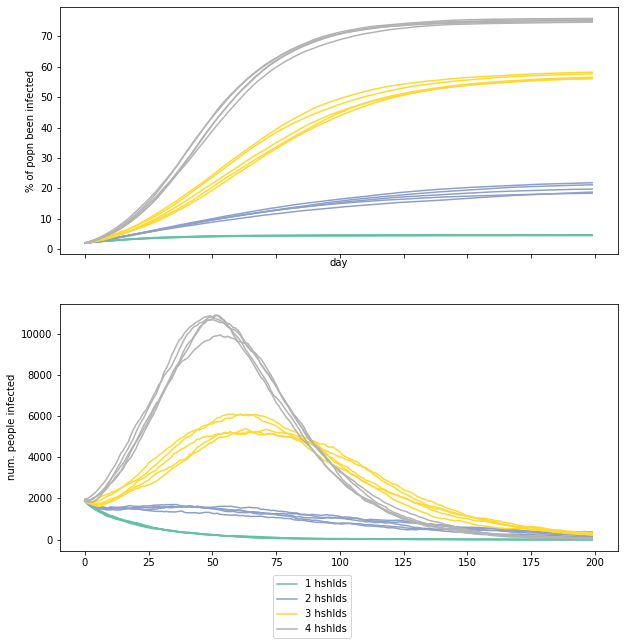

In [181]:
mat = sim2(100000, 200, 2000, 2.1, .01, 1/10, .2, 3)
fig, (ax2, ax1) = plt.subplots(2, 1, sharex = True, figsize=(10, 10))

cols = plt.get_cmap('Set2', 4)

for i in range(1, 5):
    for _ in range(5):
        mat = sim2(100000, 200, 2000, 2.1, .01, 1/10, .2, i)
        ax1.plot(mat[:, 2], color=cols(i-1), label=f'{i} hshlds')
        ax2.plot((mat[:, 2]+mat[:, 3])/1000, color=cols(i-1))
        
ax1.set_ylabel('num. people infected')
ax2.set_ylabel('% of popn been infected')
ax2.set_xlabel('day')

handles, labels = ax1.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

fig.legend(newHandles, newLabels, loc='lower center')

### Question 9

In [188]:
rs = np.array([])
for i in range(1, 5):
    mat = sim2(100000, 200, 2000, 2.1, .01, 1/10, .2, i)
    rs = np.append(rs, r(mat, 10, 25, 10))

print(rs)

[0.66100999 1.08707429 1.35915577 1.5221196 ]


## Answer Submission

## Part a

### Initialize Autograder

In [32]:
import ucamcl
GRADER = ucamcl.autograder('https://markmy.solutions', course='scicomp').subsection('tick1a')

Waiting for you to log in ... done.


### Question 1

In [11]:
q = GRADER.fetch_question('q1')
ans = trunc_sizes(q.s)
GRADER.submit_answer(q, ans)

Correct!


True

### Question 2

In [12]:
q = GRADER.fetch_question('q2')
ans = {'person_in': person_in(q.loc_sizes), 'first_occ': first_occ(q.loc_sizes)}
GRADER.submit_answer(q, ans)

Correct!


True

### Question 3

In [13]:
q = GRADER.fetch_question('q3')
ans = exposure(np.array(q.infected), q.loc_sizes)
GRADER.submit_answer(q, ans)

Correct!


True

### Question 4

In [52]:
q = GRADER.fetch_question('q4')
x = sim(q.N, q.T, q.n0, q.avg_loc_size, q.prob_infect, q.prob_recover) # fill in the rest from q
ans = x[-1,3]/q.N
GRADER.submit_answer(q, ans)

Correct!


True

## Part b

### Initialise Autograder

In [190]:
GRADER1b = ucamcl.autograder('https://markmy.solutions', course='scicomp').subsection('tick1b')

Waiting for you to log in ... done.


### Question 6

In [24]:
q = GRADER1b.fetch_question('q6')
ans = r(np.array(q.X), t0=q.t0, t1=q.t1, days=q.days)
GRADER1b.submit_answer(q, ans)

Correct!


True

### Question 7

In [150]:
q = GRADER1b.fetch_question('q7')
x = sim2(q.N, q.T, q.n0, q.avg_loc_size, q.prob_infect, q.prob_recover, q.prob_infect_home, q.num_households)
ans = x[-1,3] / q.N
GRADER1b.submit_answer(q, ans)

Correct!


True

### Question 9

In [191]:
ans = rs # array of four numbers, the R number of bubble sizes [1,2,3,4]
GRADER1b.submit_answer(GRADER1b.fetch_question('q9'), ans)

Correct!


True